In [15]:
# !pip3 install pandas --upgrade --quiet
# !pip3 install numpy --upgrade --quiet
# !pip3 install scipy  --upgrade --quiet
# !pip3 install statsmodels  --upgrade --quiet
# !pip3 install seaborn  --upgrade --quiet
# !pip3 install matplotlib  --upgrade --quiet
# !pip3 install scikit-learn  --upgrade
#!pip install scikit-optimize  --quiet
#!pip install apafib --upgrade  --quiet
#!pip install ucimlrepo --upgrade  --quiet
#!pip install -U numpy scipy scikit-learn pandas matplotlib seaborn statsmodels yellowbrick

In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

In [17]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [18]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

##a)
Divide los datos en un conjunto de entrenamiento y otro de test (70 %/30 %), la partición
debe estratificarse (fija también el estado del generador de números aleatorios para la reproducibilidad).

Haz una visualización mínima de las variables para hacerte una idea de
los datos y calcula sus correlaciones.

Verás que las variables son todas continuas. Algunas variables no parecen muy gausianas.

Haremos dos conjuntos de datos, uno que tenga las variables originales y otro en el que las variables que se desvíen bastante de la
gausianidad las transformaremos a algo más cercano a una gausiana usando el método
QuantileTransformer de scikit-learn. Este usa los cuantiles de los datos para que
coincidan con los cuantiles de la gausiana, básicamente hace corresponder la CDF empírica de los datos y la CDF teórica de la gausiana.

Normaliza adecuadamente los datos.

Cargamos los datos:


In [19]:
from apafib import load_travel_review
data = load_travel_review()
X = data.drop(columns=['class']);
y = data['class'];
X.head()
y.value_counts()

,art galleries,dance clubs,juice bars,restaurants,museums,resorts,parks/picnic spots,beaches,theaters,religious institutions
0,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


,count
class,
3,298
1,255
2,226
0,201


In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
art galleries,980.0,0.893,0.327,0.34,0.67,0.83,1.020,3.22
dance clubs,980.0,1.353,0.478,0.00,1.08,1.28,1.560,3.64
juice bars,980.0,1.013,0.789,0.13,0.27,0.82,1.573,3.62
restaurants,980.0,0.532,0.280,0.15,0.41,0.50,0.580,3.44
museums,980.0,0.940,0.437,0.06,0.64,0.90,1.200,3.30
resorts,980.0,1.843,0.540,0.14,1.46,1.80,2.200,3.76
parks/picnic spots,980.0,3.181,0.008,3.16,3.18,3.18,3.180,3.21
beaches,980.0,2.835,0.138,2.42,2.74,2.82,2.910,3.39
theaters,980.0,1.569,0.365,0.74,1.31,1.54,1.760,3.17
religious institutions,980.0,2.799,0.321,2.14,2.54,2.78,3.040,3.66


Separamos los conjuntos de test y train con la opción de stratify para que haya una proporción similar de las classes en el test y en el train.

Hacemos un conteo de cada variable para ver como estan distribuidas las variables.

Mostramos la matriz de correlaciones entre variables para ver si hay algunas que están relacionadas con otras (veremos que parece que son dependientes).

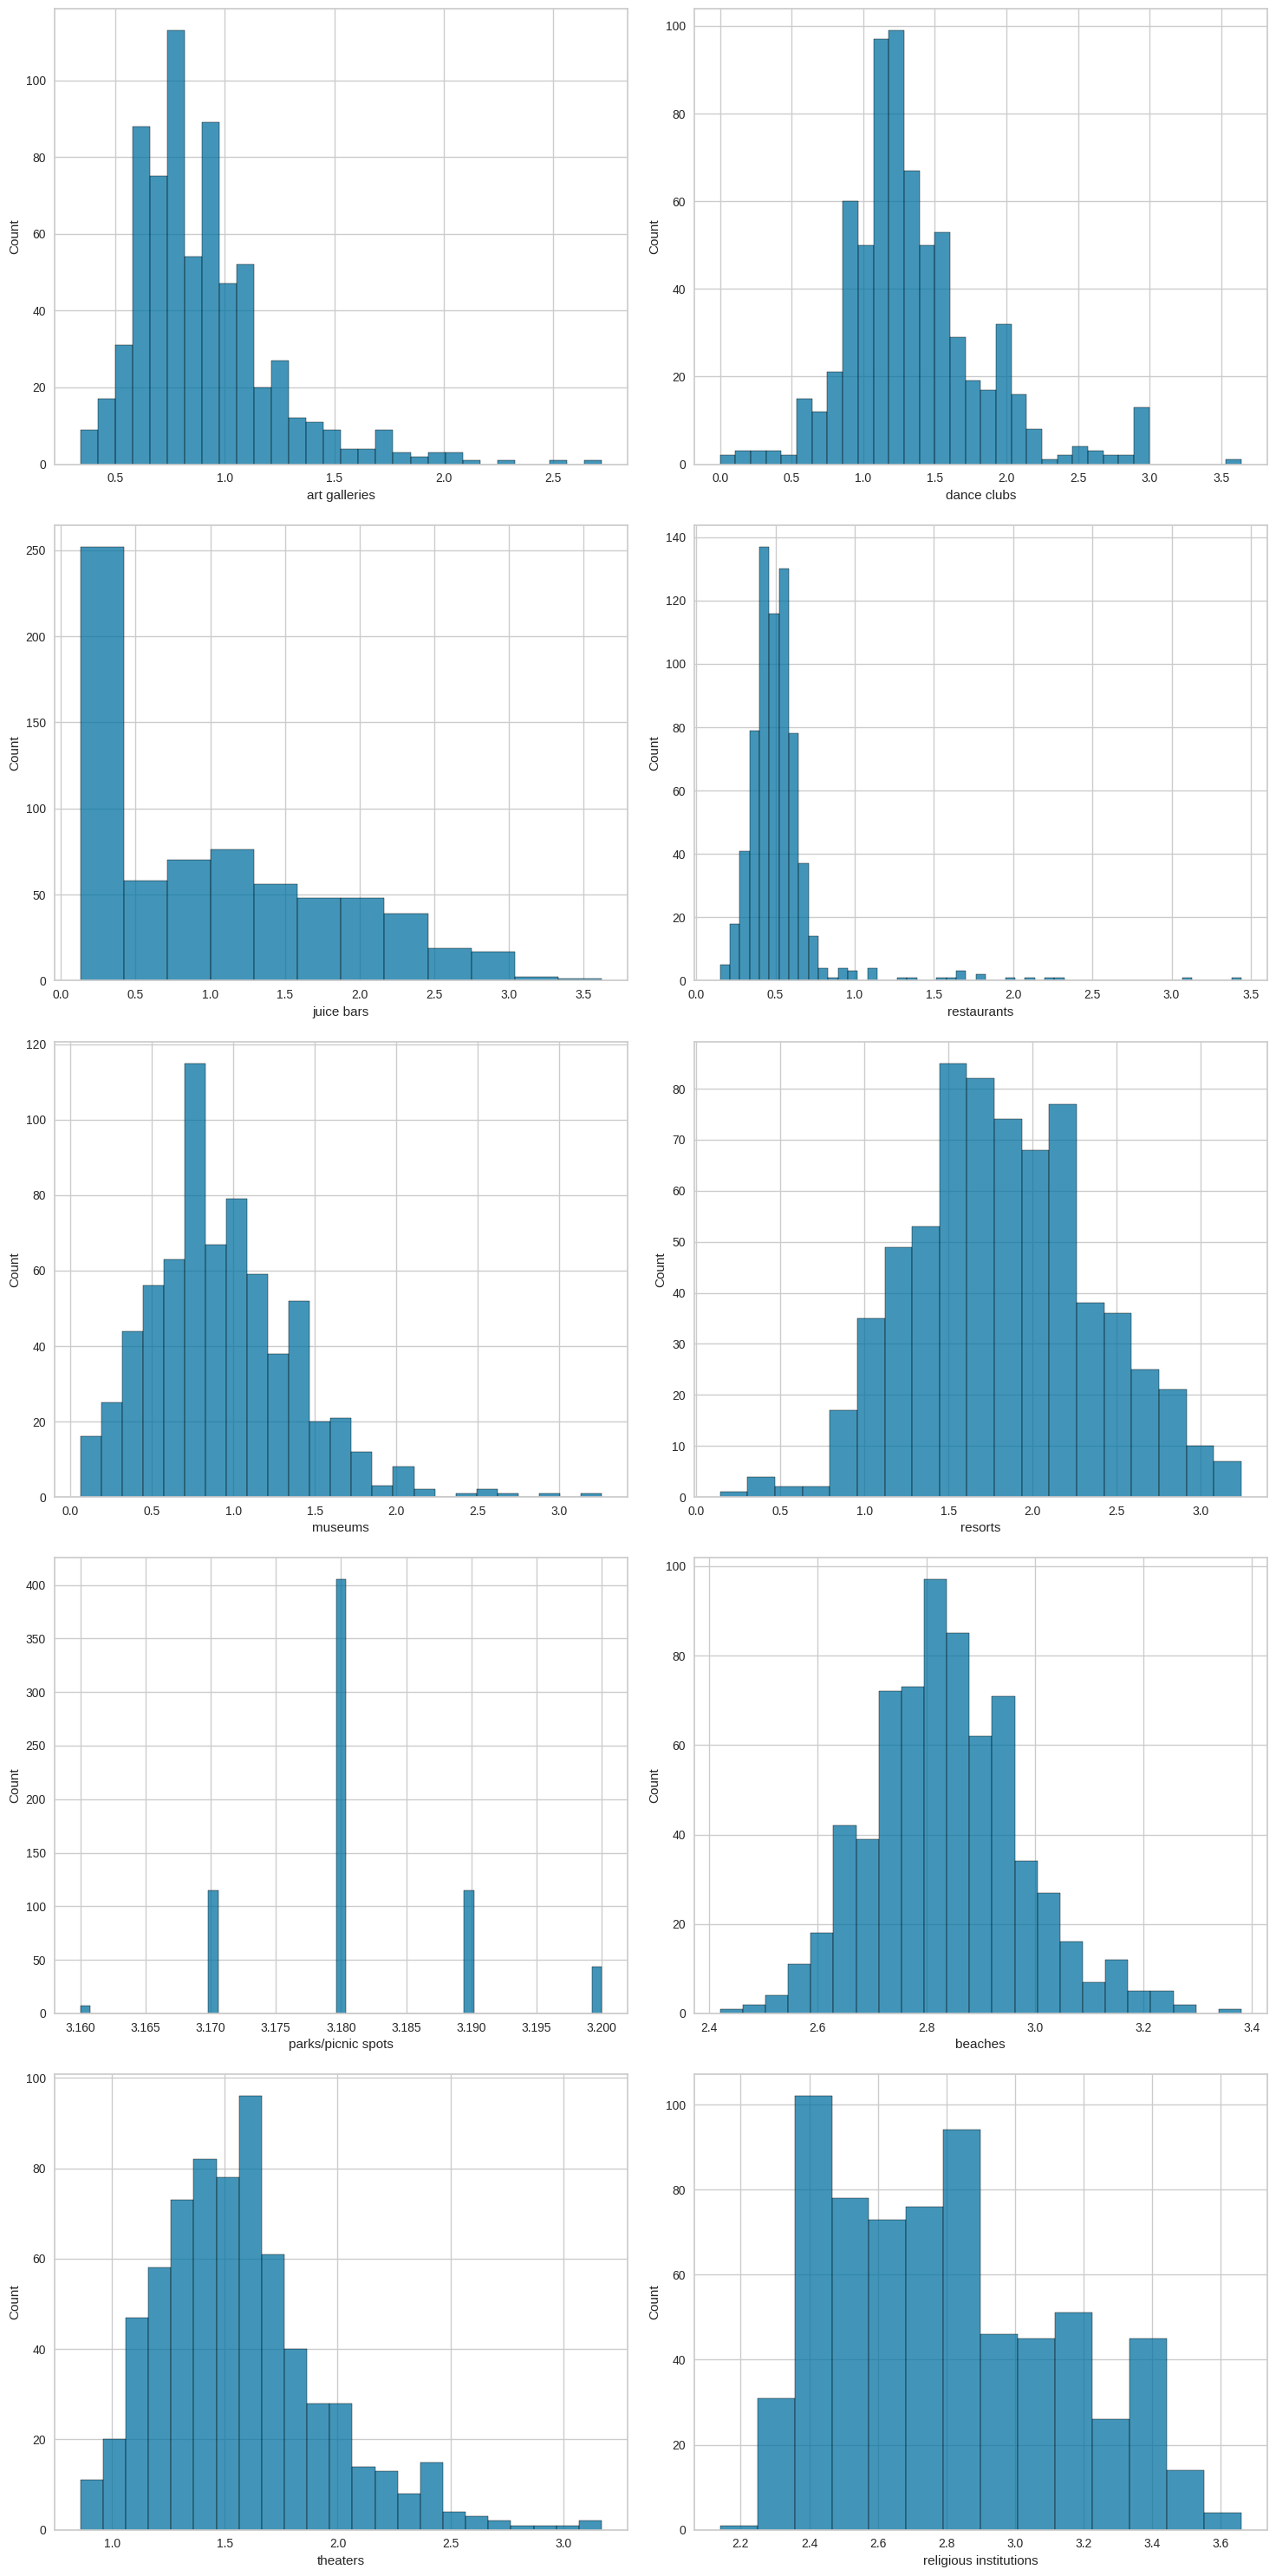

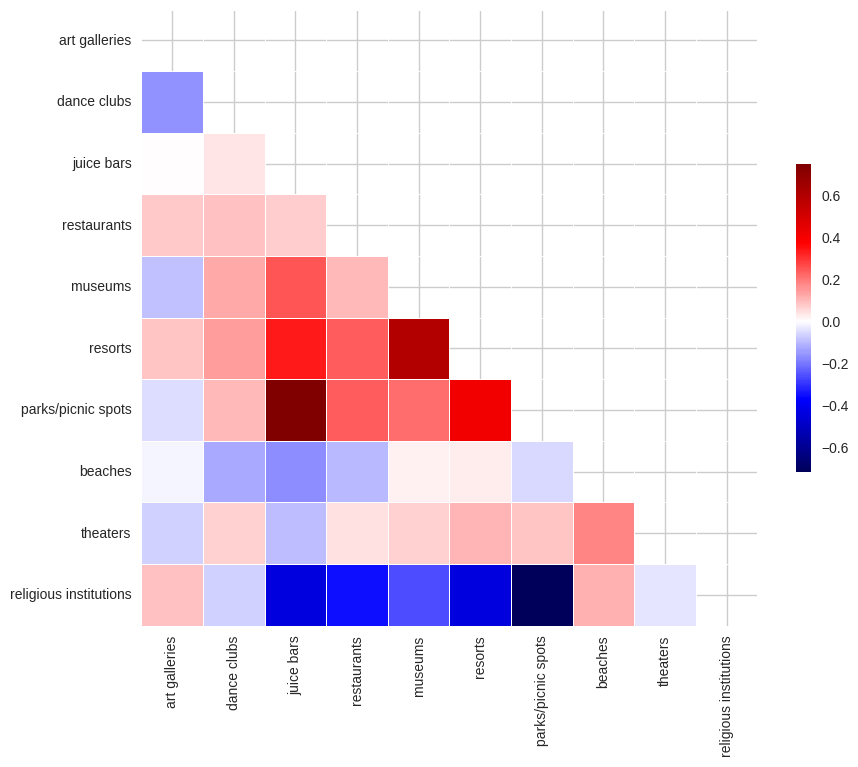

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


fig, axes = plt.subplots(5,2,figsize=(15,30))
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train_frame = pd.DataFrame(X_train)
X_train_frame.columns=X.columns
for i, c in enumerate(X.columns):
    ax = axes.reshape(-1)[i]
    if X_train_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=X_train_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=X_train_frame,ax=ax)
plt.tight_layout()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
corr = X_train_frame.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Como se observa en las gráficas podemos corroborar la parte del enunciado que dice que hay variables poco gaussianas como puede ser la variable "juice bars", a su vez también observamos algunas relaciones lineales como entre "resorts" y "museums" de forma directa igual que entre "parks/picnic spots" y "juice bars" y luego podemos ver entre "religious institutions" y "parks/picnic spots" hay una relación de forma inversa.

Ahora arreglaremos la gaussianidad usando el QuantileTransformer en las variables que más se alejen de una distribución normal y además normalizaremos las variables.

Variables con |skew| > 0.4: ['art galleries', 'dance clubs', 'juice bars', 'restaurants', 'museums', 'parks/picnic spots', 'theaters', 'religious institutions']


StandardScaler()

QuantileTransformer(output_distribution='normal', random_state=42)

StandardScaler()

<Axes: xlabel='art galleries', ylabel='Count'>

Text(0.5, 1.0, 'art galleries - Original escalado (X_train_A)')

<Axes: xlabel='art galleries', ylabel='Count'>

Text(0.5, 1.0, 'art galleries - Transformado (X_train_B)')

<Axes: xlabel='dance clubs', ylabel='Count'>

Text(0.5, 1.0, 'dance clubs - Original escalado (X_train_A)')

<Axes: xlabel='dance clubs', ylabel='Count'>

Text(0.5, 1.0, 'dance clubs - Transformado (X_train_B)')

<Axes: xlabel='juice bars', ylabel='Count'>

Text(0.5, 1.0, 'juice bars - Original escalado (X_train_A)')

<Axes: xlabel='juice bars', ylabel='Count'>

Text(0.5, 1.0, 'juice bars - Transformado (X_train_B)')

<Axes: xlabel='restaurants', ylabel='Count'>

Text(0.5, 1.0, 'restaurants - Original escalado (X_train_A)')

<Axes: xlabel='restaurants', ylabel='Count'>

Text(0.5, 1.0, 'restaurants - Transformado (X_train_B)')

<Axes: xlabel='museums', ylabel='Count'>

Text(0.5, 1.0, 'museums - Original escalado (X_train_A)')

<Axes: xlabel='museums', ylabel='Count'>

Text(0.5, 1.0, 'museums - Transformado (X_train_B)')

<Axes: xlabel='resorts', ylabel='Count'>

Text(0.5, 1.0, 'resorts - Original escalado (X_train_A)')

<Axes: xlabel='resorts', ylabel='Count'>

Text(0.5, 1.0, 'resorts - Transformado (X_train_B)')

<Axes: xlabel='parks/picnic spots', ylabel='Count'>

Text(0.5, 1.0, 'parks/picnic spots - Original escalado (X_train_A)')

<Axes: xlabel='parks/picnic spots', ylabel='Count'>

Text(0.5, 1.0, 'parks/picnic spots - Transformado (X_train_B)')

<Axes: xlabel='beaches', ylabel='Count'>

Text(0.5, 1.0, 'beaches - Original escalado (X_train_A)')

<Axes: xlabel='beaches', ylabel='Count'>

Text(0.5, 1.0, 'beaches - Transformado (X_train_B)')

<Axes: xlabel='theaters', ylabel='Count'>

Text(0.5, 1.0, 'theaters - Original escalado (X_train_A)')

<Axes: xlabel='theaters', ylabel='Count'>

Text(0.5, 1.0, 'theaters - Transformado (X_train_B)')

<Axes: xlabel='religious institutions', ylabel='Count'>

Text(0.5, 1.0, 'religious institutions - Original escalado (X_train_A)')

<Axes: xlabel='religious institutions', ylabel='Count'>

Text(0.5, 1.0, 'religious institutions - Transformado (X_train_B)')

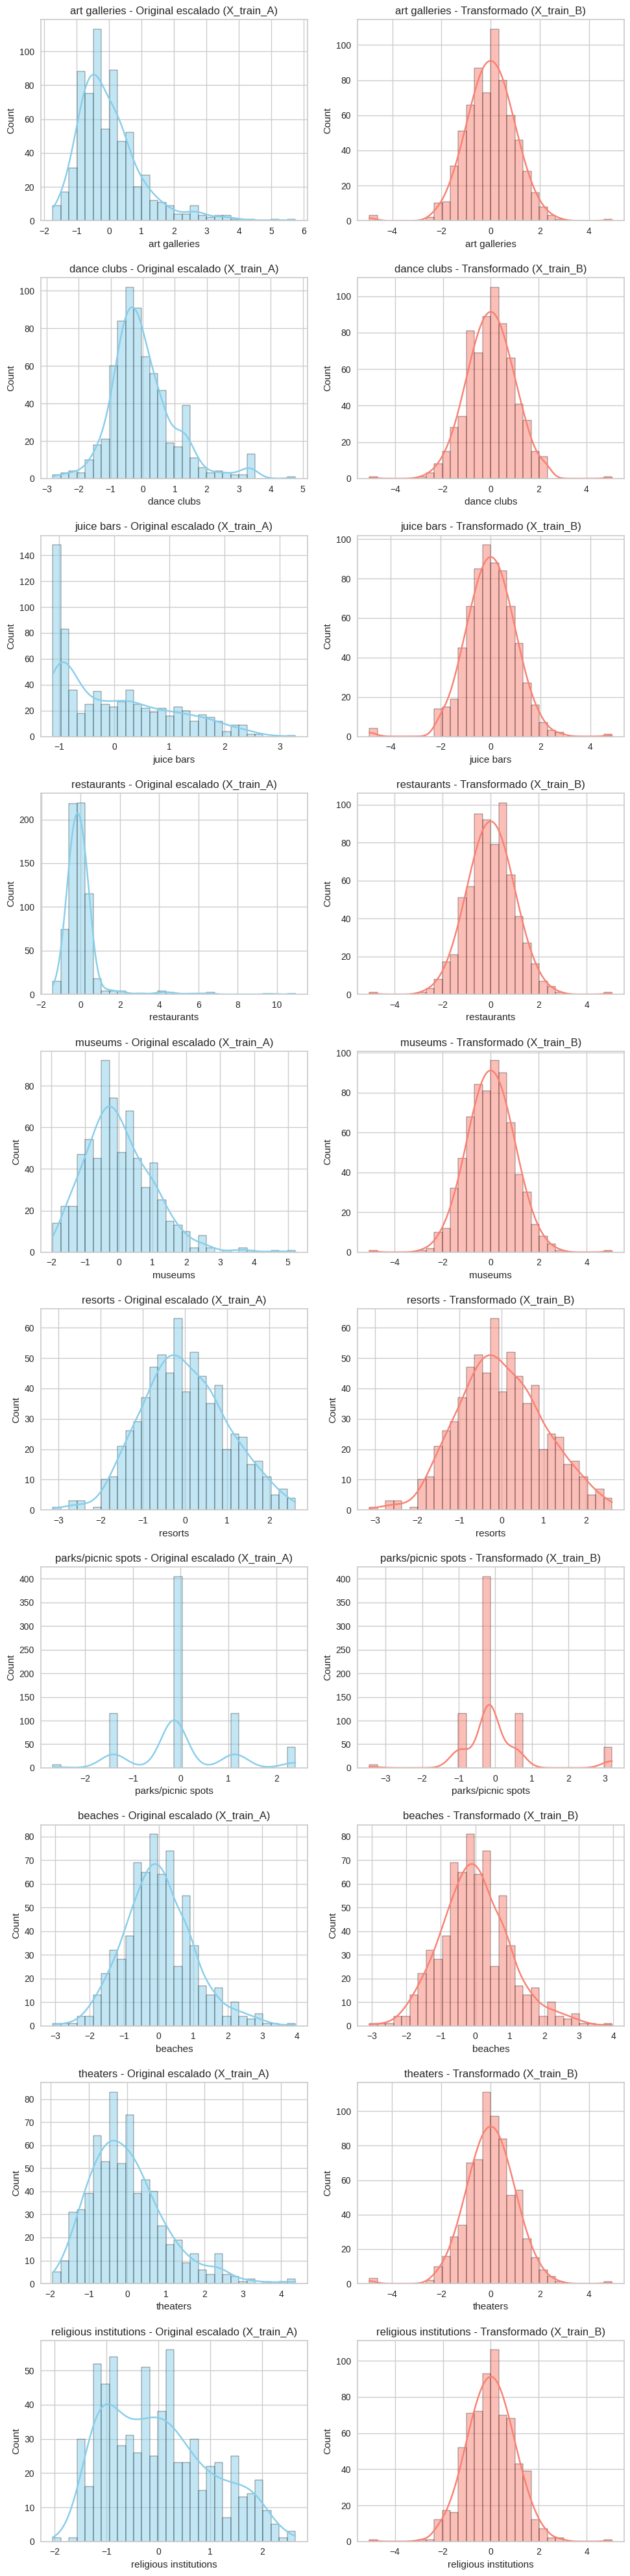

In [22]:

# === 3) Detección simple de no-gaussianidad (asimetría)
skew = X_train[num_cols].skew(numeric_only=True)
skew_thr = 0.4
skewed_feats = skew[np.abs(skew) > skew_thr].index.tolist()
print(f"Variables con |skew| > {skew_thr}: {skewed_feats}")

# === 4) Conjunto A: ORIGINAL escalado (solo StandardScaler)
scaler_A = StandardScaler()
scaler_A.fit(X_train[num_cols])  # fit SOLO en train

X_train_A = X_train.copy()
X_test_A  = X_test.copy()

X_train_A[num_cols] = pd.DataFrame(
    scaler_A.transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)

X_test_A[num_cols] = pd.DataFrame(
    scaler_A.transform(X_test[num_cols]),
    columns=num_cols,
    index=X_test.index
)

# === 5) Conjunto B: TRANSFORMADO + escalado
# 5.1) QuantileTransformer solo en variables muy no gaussianas
X_train_B = X_train.copy()
X_test_B  = X_test.copy()

if len(skewed_feats) > 0:
    qt = QuantileTransformer(output_distribution="normal", random_state=42)
    qt.fit(X_train_B[skewed_feats])  # fit SOLO en train
    X_train_B.loc[:, skewed_feats] = qt.transform(X_train_B[skewed_feats])
    X_test_B.loc[:,  skewed_feats] = qt.transform(X_test_B[skewed_feats])

# 5.2) Escalado final en todas las numéricas para homogeneizar escala
scaler_B = StandardScaler()
scaler_B.fit(X_train_B[num_cols])  # ⚠️ esta línea faltaba (fit SOLO en train)

X_train_B[num_cols] = pd.DataFrame(
    scaler_B.transform(X_train_B[num_cols]),
    columns=num_cols,
    index=X_train_B.index
)
X_test_B[num_cols] = pd.DataFrame(
    scaler_B.transform(X_test_B[num_cols]),
    columns=num_cols,
    index=X_test_B.index
)


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegurarte de que ambos tengan los nombres de columna correctos
X_train_A_df = pd.DataFrame(X_train_A, columns=X.columns)
X_train_B_df = pd.DataFrame(X_train_B, columns=X.columns)

num_cols = X.columns.tolist()

# Cuadrícula: una fila por variable, dos columnas (A y B)
fig, axes = plt.subplots(len(num_cols), 2, figsize=(10, 4*len(num_cols)))

for i, col in enumerate(num_cols):
    # Original (solo escalado)
    sns.histplot(X_train_A_df[col], bins=30, kde=True, ax=axes[i,0], color="skyblue")
    axes[i,0].set_title(f"{col} - Original escalado (X_train_A)")

    # Transformado (QuantileTransformer + escalado)
    sns.histplot(X_train_B_df[col], bins=30, kde=True, ax=axes[i,1], color="salmon")
    axes[i,1].set_title(f"{col} - Transformado (X_train_B)")

plt.tight_layout()
plt.show()


Haciendo esto obtenemos los dos conjuntos A y B donde A está normalizado pero no aproximado a una normal y B está normalizado y ajustado para que parezca una normal.

##b)
Empezaremos por Naïve Bayes, ajusta un modelo para distribuciones gausianas a los dos
conjuntos de datos y evalúa adecuadamente la calidad de los modelos.


Conjunto A
R2: 0.7377877237851662
Priors: [0.20553936 0.25947522 0.2303207  0.30466472]
Means:

              precision    recall  f1-score   support

           0       0.55      0.65      0.60        60
           1       0.77      0.77      0.77        77
           2       0.79      0.50      0.61        68
           3       0.70      0.81      0.75        89

    accuracy                           0.69       294
   macro avg       0.70      0.68      0.68       294
weighted avg       0.71      0.69      0.69       294



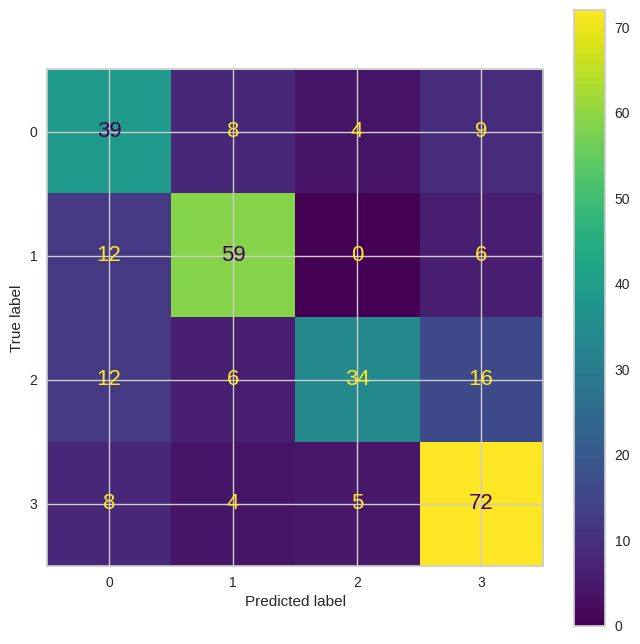

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score
print('Conjunto A')
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train_A,y_train,cv=10))
print('R2:',gnb.best_score_)

gnb_model = GaussianNB().fit(X_train_A, y_train)
gnb_model.best_score_ = gnb.best_score_

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X_train_A.columns
means

print(classification_report(y_test, gnb_model.predict(X_test_A), target_names=['0', '1','2','3']))
results_df = save_results(gnb_model, X_test_A, y_test, 'GNB', results_df)

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_A,y_test, display_labels=['0', '1','2','3'], ax=plt.subplot());


Conjunto B
R2: 0.7246376811594203
Priors: [0.20553936 0.25947522 0.2303207  0.30466472]
Means:

              precision    recall  f1-score   support

           0       0.61      0.73      0.67        60
           1       0.74      0.75      0.75        77
           2       0.78      0.68      0.72        68
           3       0.81      0.78      0.79        89

    accuracy                           0.74       294
   macro avg       0.74      0.73      0.73       294
weighted avg       0.75      0.74      0.74       294



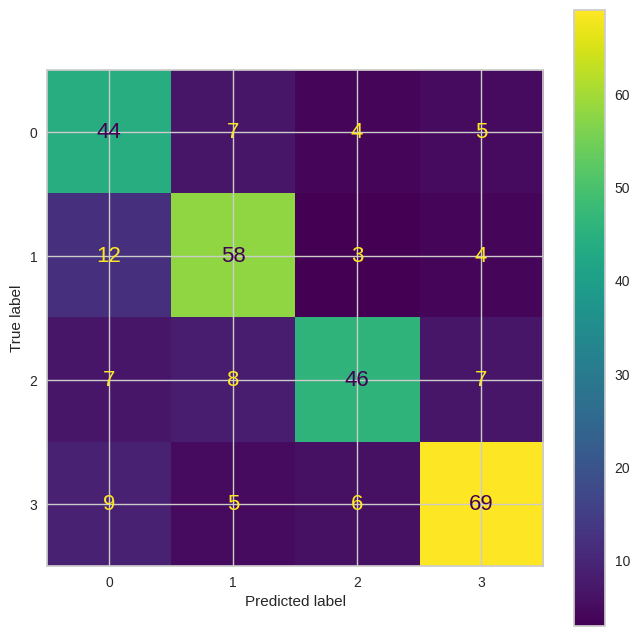

In [24]:
print('Conjunto B')
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train_B,y_train,cv=10))
print('R2:',gnb.best_score_)

gnb_model = GaussianNB().fit(X_train_B, y_train)
gnb_model.best_score_ = gnb.best_score_

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X_train_B.columns
means

print(classification_report(y_test, gnb_model.predict(X_test_B), target_names=['0', '1','2','3']))
results_df = save_results(gnb_model, X_test_B, y_test, 'GNB', results_df)

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_B,y_test, display_labels=['0', '1','2','3'], ax=plt.subplot());

Como se puede observar en los dos modelos, el modelo A da un peor resultado claramente que el modelo B ya que en el A se asume normalidad cuando no la hay en cambio en el B se ha intentado que si que la haya

0.7595055413469736
Priors: [0.20553936 0.25947522 0.2303207  0.30466472]
Means:

Intercepts:
Explained Variance Ratio
Coefs:


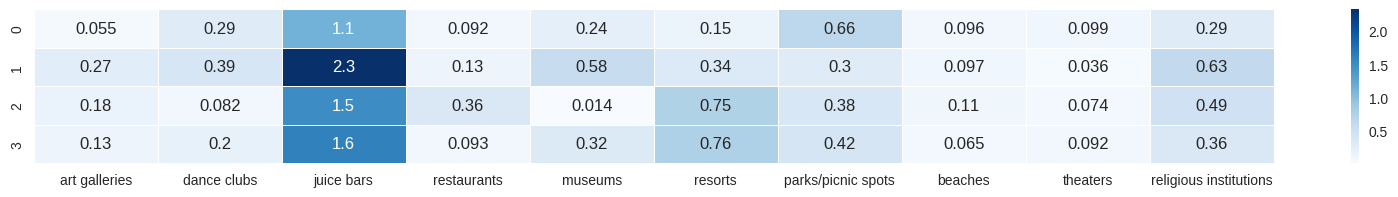

In [25]:
lda = LinearDiscriminantAnalysis()
lda.best_score_ = np.mean(cross_val_score(lda,X_train_A,y_train,cv=10))
print(lda.best_score_)

lda_model = LinearDiscriminantAnalysis().fit(X_train_A, y_train)

print('Priors:', lda_model.priors_)
print('Means:\n')
means =pd.DataFrame(lda_model.means_)
means.columns=X.columns
means

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts

print('Explained Variance Ratio')
pd.DataFrame(lda_model.explained_variance_ratio_ )

print('Coefs:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = X.columns
# coefs.T

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

              precision    recall  f1-score   support

           0       0.72      0.43      0.54        60
           1       0.71      0.84      0.77        77
           2       0.75      0.75      0.75        68
           3       0.79      0.87      0.82        89

    accuracy                           0.74       294
   macro avg       0.74      0.72      0.72       294
weighted avg       0.74      0.74      0.73       294



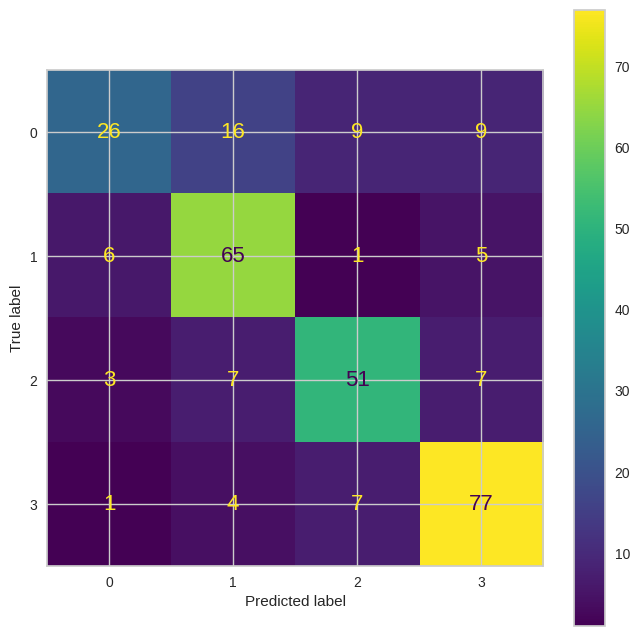

In [26]:
lda_model.best_score_ = lda.best_score_
print(classification_report(y_test, lda_model.predict(X_test_A), target_names=['0', '1','2','3']))
results_df = save_results(lda_model, X_test_A, y_test, 'LDA', results_df)

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda_model, X_test_A,y_test, display_labels=['0', '1','2','3'], ax=plt.subplot());


0.7390025575447571
Priors: [0.20553936 0.25947522 0.2303207  0.30466472]
Means:

Intercepts:
Explained Variance Ratio
Coefs:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54        60
           1       0.71      0.77      0.74        77
           2       0.73      0.69      0.71        68
           3       0.78      0.81      0.80        89

    accuracy                           0.71       294
   macro avg       0.70      0.70      0.70       294
weighted avg       0.71      0.71      0.71       294



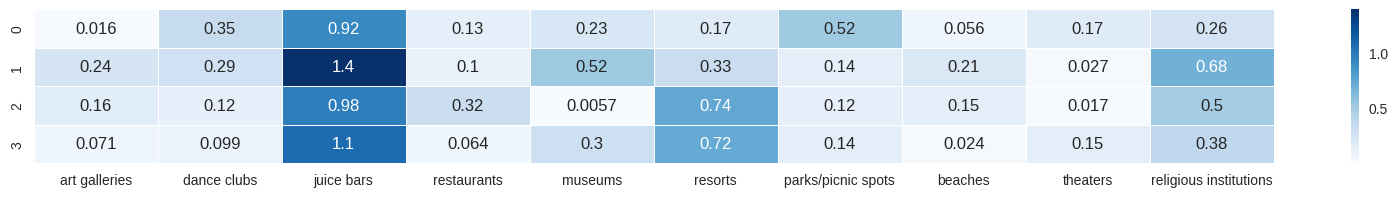

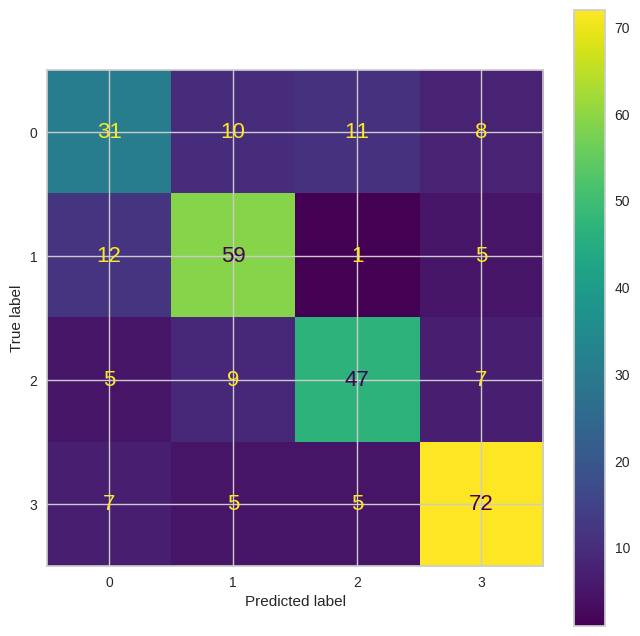

In [27]:
lda = LinearDiscriminantAnalysis()
lda.best_score_ = np.mean(cross_val_score(lda,X_train_B,y_train,cv=10))
print(lda.best_score_)

lda_model = LinearDiscriminantAnalysis().fit(X_train_B, y_train)

print('Priors:', lda_model.priors_)
print('Means:\n')
means =pd.DataFrame(lda_model.means_)
means.columns=X.columns
means

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts

print('Explained Variance Ratio')
pd.DataFrame(lda_model.explained_variance_ratio_ )

print('Coefs:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = X.columns
# coefs.T

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

lda_model.best_score_ = lda.best_score_
print(classification_report(y_test, lda_model.predict(X_test_B), target_names=['0', '1','2','3']))
results_df = save_results(lda_model, X_test_B, y_test, 'LDA', results_df)

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda_model, X_test_B,y_test, display_labels=['0', '1','2','3'], ax=plt.subplot());

=== LOGISTIC en X_train_A / X_test_A (sin class_weight) ===

==> Mejor CV (R^2): 0.7681
==> Balanced accuracy (test): 0.7153

Classification report (test):
              precision    recall  f1-score   support

           0       0.74      0.42      0.53        60
           1       0.69      0.84      0.76        77
           2       0.76      0.74      0.75        68
           3       0.77      0.87      0.81        89

    accuracy                           0.74       294
   macro avg       0.74      0.72      0.71       294
weighted avg       0.74      0.74      0.73       294



<Figure size 600x600 with 0 Axes>

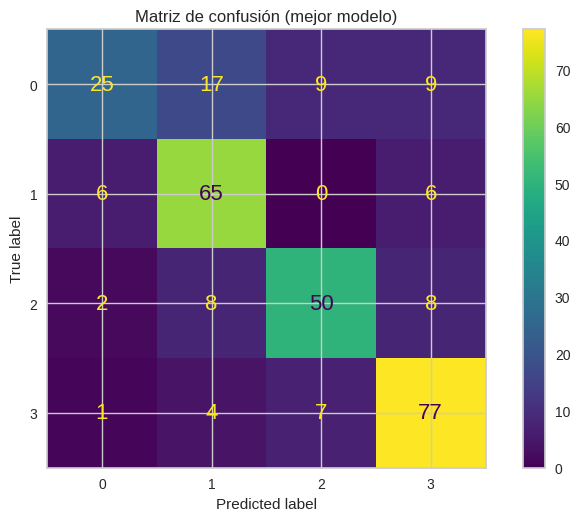


Top atributos por clase (|coef|):
  Clase 0: ['juice bars', 'parks/picnic spots', 'dance clubs', 'museums', 'religious institutions']
  Clase 1: ['juice bars', 'museums', 'religious institutions', 'dance clubs', 'parks/picnic spots']
  Clase 2: ['juice bars', 'resorts', 'religious institutions', 'parks/picnic spots', 'restaurants']
  Clase 3: ['juice bars', 'resorts', 'parks/picnic spots', 'museums', 'religious institutions']

Ranking global por |coef| medio:
juice bars                1.302
resorts                   0.504
parks/picnic spots        0.308
religious institutions    0.288
museums                   0.285
dance clubs               0.228
restaurants               0.135
art galleries             0.113
theaters                  0.072
beaches                   0.059
dtype: float64

=== LOGISTIC en X_train_A / X_test_A (class_weight='balanced') ===

==> Mejor CV (R^2): 0.7958
==> Balanced accuracy (test): 0.7577

Classification report (test):
              precision    recall  f

<Figure size 600x600 with 0 Axes>

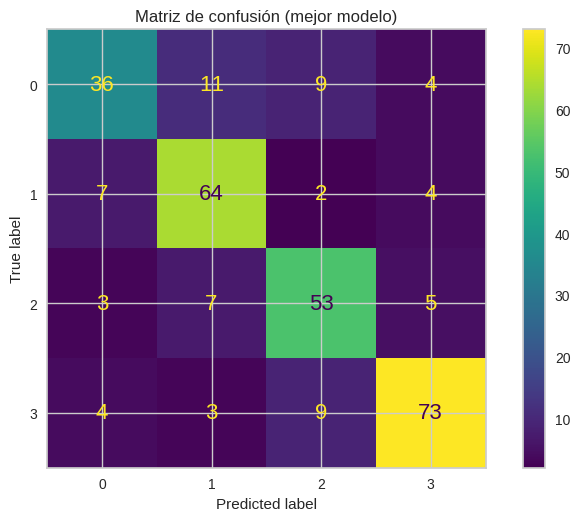


Top atributos por clase (|coef|):
  Clase 0: ['juice bars', 'dance clubs', 'museums', 'parks/picnic spots', 'resorts']
  Clase 1: ['juice bars', 'museums', 'religious institutions', 'resorts', 'dance clubs']
  Clase 2: ['juice bars', 'resorts', 'religious institutions', 'restaurants', 'dance clubs']
  Clase 3: ['juice bars', 'resorts', 'museums', 'religious institutions', 'dance clubs']

Ranking global por |coef| medio:
juice bars                1.100
resorts                   0.483
museums                   0.287
religious institutions    0.217
dance clubs               0.216
restaurants               0.117
parks/picnic spots        0.113
art galleries             0.100
beaches                   0.064
theaters                  0.061
dtype: float64

=== LOGISTIC en X_train_B / X_test_B (sin class_weight) ===

==> Mejor CV (R^2): 0.7550
==> Balanced accuracy (test): 0.7232

Classification report (test):
              precision    recall  f1-score   support

           0       0.67     

<Figure size 600x600 with 0 Axes>

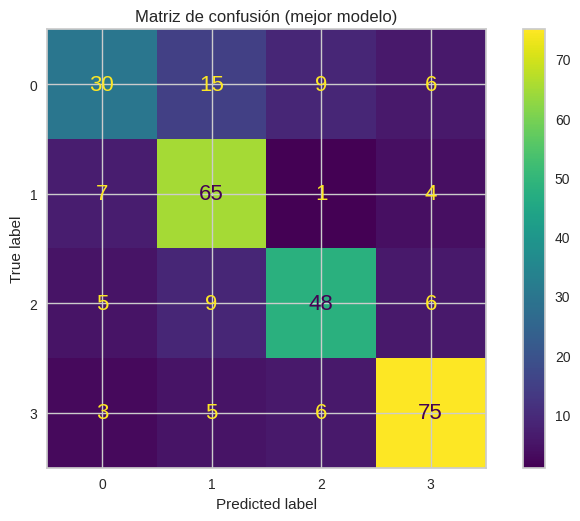


Top atributos por clase (|coef|):
  Clase 0: ['juice bars', 'parks/picnic spots', 'dance clubs', 'museums', 'religious institutions']
  Clase 1: ['juice bars', 'museums', 'religious institutions', 'resorts', 'dance clubs']
  Clase 2: ['juice bars', 'resorts', 'religious institutions', 'parks/picnic spots', 'restaurants']
  Clase 3: ['juice bars', 'resorts', 'parks/picnic spots', 'religious institutions', 'museums']

Ranking global por |coef| medio:
juice bars                1.337
resorts                   0.481
religious institutions    0.325
parks/picnic spots        0.323
museums                   0.277
dance clubs               0.200
restaurants               0.116
art galleries             0.102
theaters                  0.087
beaches                   0.069
dtype: float64

=== LOGISTIC en X_train_B / X_test_B (class_weight='balanced') ===

==> Mejor CV (R^2): 0.7769
==> Balanced accuracy (test): 0.7327

Classification report (test):
              precision    recall  f1-score   s

<Figure size 600x600 with 0 Axes>

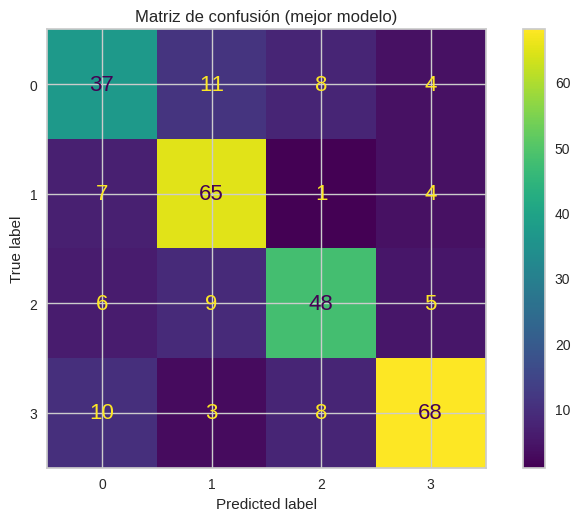


Top atributos por clase (|coef|):
  Clase 0: ['juice bars', 'parks/picnic spots', 'museums', 'dance clubs', 'religious institutions']
  Clase 1: ['juice bars', 'museums', 'religious institutions', 'resorts', 'parks/picnic spots']
  Clase 2: ['juice bars', 'resorts', 'religious institutions', 'parks/picnic spots', 'restaurants']
  Clase 3: ['juice bars', 'resorts', 'parks/picnic spots', 'religious institutions', 'museums']

Ranking global por |coef| medio:
juice bars                1.437
resorts                   0.496
parks/picnic spots        0.363
religious institutions    0.348
museums                   0.290
dance clubs               0.206
restaurants               0.113
art galleries             0.109
theaters                  0.087
beaches                   0.070
dtype: float64

Resumen balanced accuracy (test):
   setup  balanced_acc_test
1  A_bal              0.758
3  B_bal              0.733
2      B              0.723
0      A              0.715


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def run_logreg_grid(X_train, y_train, X_test, y_test, class_weight=None, scoring='R^2'):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    Cs = np.logspace(-3, 3, 21)

    # Dos grids válidos por solver/penalty
    grids = [
        {
            "estimator": LogisticRegression(max_iter=10000, solver="liblinear",
                                            class_weight=class_weight, multi_class="ovr"),
            "param_grid": {"penalty": ["l1","l2"], "C": Cs}
        },
        {
            "estimator": LogisticRegression(max_iter=10000, solver="lbfgs",
                                            class_weight=class_weight, multi_class="multinomial"),
            "param_grid": {"penalty": ["l2"], "C": Cs}
        }
        # (Opcional) añadir saga con ["l1","l2"]
    ]

    best_model = None
    best_cv = -np.inf
    best_res = None

    for g in grids:
        gs = GridSearchCV(
            g["estimator"], g["param_grid"],
            cv=cv, n_jobs=-1, refit=True
        )
        gs.fit(X_train, y_train)
        mean_cv = gs.best_score_
        if mean_cv > best_cv:
            best_cv = mean_cv
            best_model = gs.best_estimator_
            best_res = pd.DataFrame(gs.cv_results_)[["params","mean_test_score","rank_test_score"]] \
                         .sort_values("rank_test_score").reset_index(drop=True)

    # Test
    y_pred = best_model.predict(X_test)
    test_bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"\n==> Mejor CV ({scoring}): {best_cv:.4f}")
    print(f"==> Balanced accuracy (test): {test_bal_acc:.4f}")
    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    plt.figure(figsize=(6,6))
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
    plt.title("Matriz de confusión (mejor modelo)")
    plt.tight_layout()
    plt.show()

    # Coefs (interpretación)
    coefs = pd.DataFrame(best_model.coef_, columns=list(X_train.columns))
    print("\nTop atributos por clase (|coef|):")
    for i in range(coefs.shape[0]):
        top = coefs.iloc[i].abs().sort_values(ascending=False).head(5)
        print(f"  Clase {i}: {list(top.index)}")

    # Ranking global por magnitud media
    global_rank = coefs.abs().mean(axis=0).sort_values(ascending=False)
    print("\nRanking global por |coef| medio:")
    print(global_rank.head(10))

    return best_model, best_res, coefs, test_bal_acc

# ---- Ejecutar en el conjunto A (original escalado)
print("=== LOGISTIC en X_train_A / X_test_A (sin class_weight) ===")
best_A, res_A, coefs_A, acc_A = run_logreg_grid(X_train_A, y_train, X_test_A, y_test, class_weight=None)

print("\n=== LOGISTIC en X_train_A / X_test_A (class_weight='balanced') ===")
best_A_bal, res_A_bal, coefs_A_bal, acc_A_bal = run_logreg_grid(X_train_A, y_train, X_test_A, y_test, class_weight="balanced")

# ---- Ejecutar en el conjunto B (QT + escalado)
print("\n=== LOGISTIC en X_train_B / X_test_B (sin class_weight) ===")
best_B, res_B, coefs_B, acc_B = run_logreg_grid(X_train_B, y_train, X_test_B, y_test, class_weight=None)

print("\n=== LOGISTIC en X_train_B / X_test_B (class_weight='balanced') ===")
best_B_bal, res_B_bal, coefs_B_bal, acc_B_bal = run_logreg_grid(X_train_B, y_train, X_test_B, y_test, class_weight="balanced")

# ---- Comparativa final para elegir modelo (usa la métrica que priorices)
summary = pd.DataFrame({
    "setup": ["A","A_bal","B","B_bal"],
    "balanced_acc_test": [acc_A, acc_A_bal, acc_B, acc_B_bal]
}).sort_values("balanced_acc_test", ascending=False)
print("\nResumen balanced accuracy (test):")
print(summary)
